In [1]:
from sklearn.datasets import load_boston

boston = load_boston()

print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [2]:
features, labels = boston.data, boston.target

In [3]:
print("Examples number:", features.shape[0])
print("Features number:", features.shape[1])

Examples number: 506
Features number: 13


**Find the number of main influence features:**

In [4]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

forest = RandomForestRegressor()
forest.fit(features, labels)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

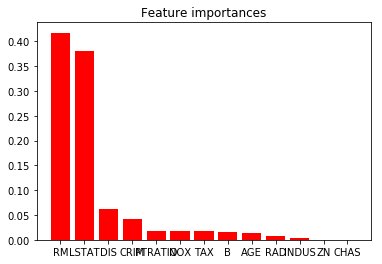

In [5]:
import matplotlib.pyplot as plt

plt.title("Feature importances")
plt.bar(range(features.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(features.shape[1]), boston.feature_names[indices])
plt.xlim([-1, features.shape[1]])
plt.show()

From this plot we can choose features, which have the greatest impact to prediction. Let's choose first 4 features.

Let's observe relations between features and the target.  
**To reduce graph size we will plot relationships in a dataset between 4 main features and the target:**

In [6]:
import seaborn as sbn
import pandas as pd

col_names = boston.feature_names.tolist() + ['target']
df = pd.DataFrame(data=np.c_[features, labels], 
                  columns=col_names)

top_indices = indices[0:4]

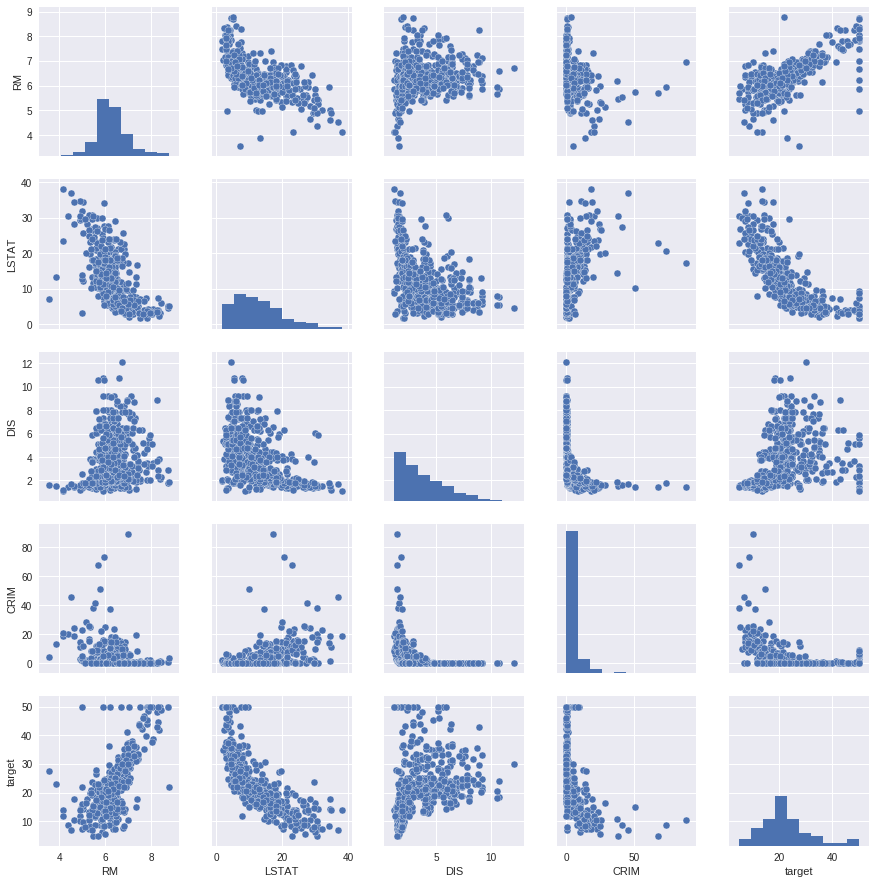

In [7]:
sbn.pairplot(df[boston.feature_names[top_indices].tolist() + ['target']])
sbn.plt.show()

**Split the data:**

In [8]:
import sklearn.model_selection as ms

In [9]:
train_features, dev_test_features, train_labels, dev_test_labels = \
  ms.train_test_split(features, labels, train_size=0.8, random_state=228)
    
print("Train features examples number:", train_features.shape[0])
print("Train labels examples number:", train_labels.shape[0])

Train features examples number: 404
Train labels examples number: 404


In [10]:
dev_features, test_features, dev_labels, test_labels = \
  ms.train_test_split(dev_test_features, dev_test_labels, train_size=0.5, random_state=228)

print("Development features examples number:", dev_features.shape[0])
print("Development labels examples number:", dev_labels.shape[0])

Development features examples number: 51
Development labels examples number: 51


In this project we will predict houses prices, that's why **it's a regression task**

**Fit and test a model function:**

In [11]:
import sklearn.metrics

def fit_and_test(model, train_features, train_labels):
    model.fit(train_features, train_labels)
    print("Coefficient of determination on the training set: %0.3f"\
      % model.score(train_features, train_labels))

    cv = ms.KFold(3, shuffle=True, random_state=228)
    scores = ms.cross_val_score(model, train_features, train_labels, cv=cv)
    print("Avg coefficient of determination using crossvalidation: %0.3f" % scores.mean())

**The function for predicting values on a test set and measuring the perfomance:**

In [12]:
def predict_and_evaluate(model, test_features, test_labels):
    predicted_test_labels = model.predict(test_features)
    
    cv = ms.KFold(3, shuffle=True, random_state=228)
    scores = ms.cross_val_score(model, test_features, test_labels, cv=cv)
    print("Avg coefficient of determination using crossvalidation: %0.3f" % scores.mean())
    
    print("Explained variance score: %0.3f" %
      sklearn.metrics.explained_variance_score(test_labels, 
                                               predicted_test_labels))
    print("Mean squared error:       %0.3f" %
      sklearn.metrics.mean_squared_error(test_labels, 
                                         predicted_test_labels))
    print("R2 score:                 %0.3f" %
      sklearn.metrics.r2_score(test_labels, 
                               predicted_test_labels))
   
    plot_predicted_measured(test_labels, predicted_test_labels)

**Graphical perfomance evaluation:**

In [13]:
def plot_predicted_measured(test_labels, predicted_test_labels):
    fig, ax = plt.subplots()
    ax.scatter(test_labels, predicted_test_labels)
    ax.plot([test_labels.min(), test_labels.max()], 
            [predicted_test_labels.min(), predicted_test_labels.max()], 
            'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()

**Create and test linear model (dumb baseline):**

In [14]:
from sklearn import linear_model

lr_model = linear_model.LinearRegression()
fit_and_test(lr_model, train_features, train_labels)

Coefficient of determination on the training set: 0.754
Avg coefficient of determination using crossvalidation: 0.725


Avg coefficient of determination using crossvalidation: 0.168
Explained variance score: 0.697
Mean squared error:       40.889
R2 score:                 0.692


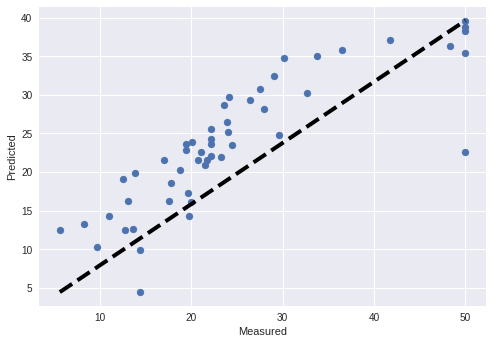

In [15]:
predict_and_evaluate(lr_model, dev_features, dev_labels)

As you can see the result is very bad.

**Create an XGBOOST model:**

In [16]:
import xgboost

xgb_model = xgboost.XGBRegressor()
fit_and_test(xgb_model, train_features, train_labels)

Coefficient of determination on the training set: 0.970
Avg coefficient of determination using crossvalidation: 0.831


Avg coefficient of determination using crossvalidation: 0.710
Explained variance score: 0.925
Mean squared error:       10.552
R2 score:                 0.921


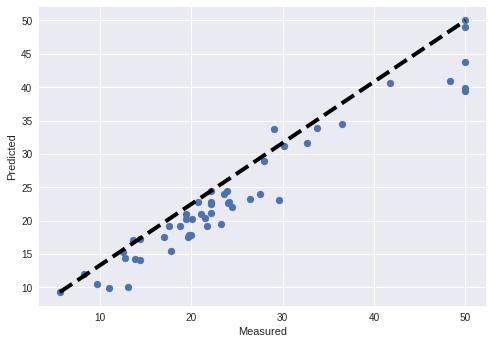

In [17]:
predict_and_evaluate(xgb_model, dev_features, dev_labels)

Here you can see that the XGBregressor model gives us better results in comparison with the baseline.  
But still it's fitted not good.  

**Let's find appropriate hyperparameters for XGBoost model:**

The scikit provides the capability to search combinations of parameters.  
This capability is provided in the GridSearchCV class and can be used to discover the best way to configure the model for top performance.

In [22]:
def find_best_params(model, param_grid, train_features, train_labels):
    cv = ms.KFold(n_splits=3, shuffle=True, random_state=228)
    grid_search = ms.GridSearchCV(model, param_grid, cv=cv)
    grid_result = grid_search.fit(train_features, train_labels)
    
    print("Best: %0.4f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [47]:
n_estimators = [50, 75, 85, 100, 150, 200, 300]
max_depth = [2, 3, 4, 5, 6, 8]
learning_rate = [0.001, 0.01, 0.1]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate)

find_best_params(xgboost.XGBRegressor(), param_grid, train_features, train_labels)

Best: 0.8322 using {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}


**Test XGBoost model with found parameters:**

In [48]:
xgb_model_opt = xgboost.XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.1)
fit_and_test(xgb_model_opt, train_features, train_labels)

Coefficient of determination on the training set: 0.997
Avg coefficient of determination using crossvalidation: 0.832


Avg coefficient of determination using crossvalidation: 0.721
Explained variance score: 0.914
Mean squared error:       12.558
R2 score:                 0.905


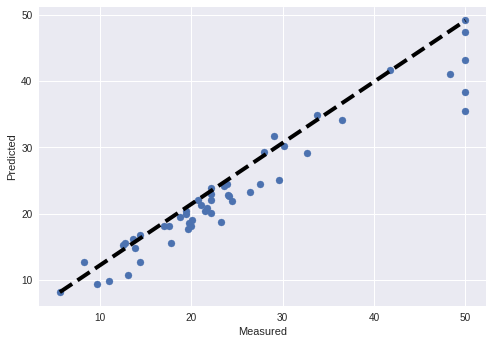

In [49]:
predict_and_evaluate(xgb_model_opt, dev_features, dev_labels)

Test on a testing set:

Avg coefficient of determination using crossvalidation: 0.393
Explained variance score: 0.929
Mean squared error:       6.003
R2 score:                 0.922


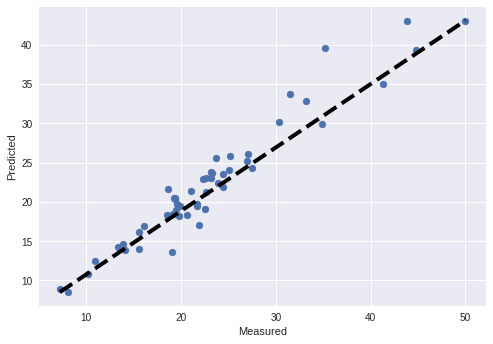

In [50]:
predict_and_evaluate(xgb_model_opt, test_features, test_labels)

After testing trained xgboost model with matched hyperparameters we've got a little bit better results in comparison with baseline xgboost model.  
The testing on a test set gives worse results, but it's still better than linear regression model results. It can be said that we are faced with overfitting on a training set.